# Devoir 2 &mdash; Détection et mise en correspondance de primitives
## Récupération des fichiers dans Colab

In [1]:
#
# Exécutez cette cellule pour préparer votre environnement Colab.
#
# %%capture
# !wget https://benhadid.github.io/m1vpo/static_files/assignments/hw1.zip
# !unzip hw1.zip
# !mv hw1/* .
# !rm -rf hw1
# !rm -rf hw1.zip

## Initialisation du bloc-notes

In [1]:
# Numpy est le paquetage principal utilisé pour le calcul scientifique dans Python.
import numpy as np

# cv2 est le paquetage OpenCV pour Python - il est utilisé pour implémenter/utiliser
# des fonctionnalités en traitement d'images et/ou vision par ordinateur
import cv2

# Ce module fournit une interface standard pour extraire, formater et imprimer
# les traces de pile des programmes Python
import traceback

# PIL (Python Image Library) est un paquetage utilisé pour manipuler les images sous Python
from PIL import Image

# pyplot fournit les fonctions de dessin de plots et d'images
import matplotlib.pyplot as plt

# Chargement du fichier de l'étudiant - c.-à-d. le fichier features.py
import features

# Quelques instructions supplémentaires pour que le notebook recharge les modules externes en python;
# voir http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# Sauvegarde et chargement de points cv2
def pickle_cv2(arr):
    index = []
    for point in arr:
        temp = (point.pt, point.size, point.angle, point.response, point.octave, point.class_id)
        index.append(temp)
    return np.array(index, dtype=object)

def unpickle_cv2(arr):
    index = []
    for point in arr:
        temp = cv2.KeyPoint(x=point[0][0],
                            y=point[0][1],
                            size=point[1],
                            angle=point[2],
                            response=point[3],
                            octave=point[4],
                            class_id=point[5])
        index.append(temp)
    return np.array(index)

# Fonctions pour tester l'exactitude de deux tableaux élément-par-élément
def compare_array(arr1, arr2):
    return np.allclose(arr1,arr2,rtol=1e-3,atol=1e-5)

# Fonction pour comparer deux points cv2
def compare_cv2_points(pnt1, pnt2):
    if not np.isclose(pnt1.pt[0],pnt2.pt[0],rtol=1e-3,atol=1e-5): return False
    if not np.isclose(pnt1.pt[1],pnt2.pt[1],rtol=1e-3,atol=1e-5): return False
    if not np.isclose(pnt1.angle,pnt2.angle,rtol=1e-3,atol=1e-5): return False
    if not np.isclose(pnt1.response,pnt2.response,rtol=1e-3,atol=1e-5): return False
    return True

# fonction appelée pour tester les différentes tâches à implémenter
def try_this(todo, run, truth, compare, *args, **kargs):
    '''
    Exécute une fonction, teste le résultat avec 'compare', et affiche un message
    d'erreur si ça ne fonctionne pas.
    @arg todo (int or str): Le numéro du TODO
    @arg run (func): La fonction à exécuter
    @arg truth (any): Le résultat correct  de la fonction testée
    @arg compare (func->bool): retourne un booléen de la comparaison de la sortie de la fonction `run` avec le résultat correct
    @arg *args (any): Arguments supplémentaires éventuels à passer à la fonction `run`
    @arg **kargs (any): Arguments supplémentaires éventuels à passer à la fonction `compare`

    @return (int): Le nombre de tests qui ont échoué
    '''
    print('Starting test for TODO {}'.format(todo))
    failed = 0
    try:
        output = run(*args)
    except Exception as e:
        traceback.print_exc()
        print("TODO {} threw an exception, see exception below\n".format(todo))
        failed += 1
        return failed

    if type(output) is list or type(output) is tuple:
        for i in range(len(output)):
            if not compare(output[i], truth[i], **kargs):
                print("TODO {} doesn't pass test: {}".format(todo, i))
                failed+=1
    else:
        if not compare(output, truth, **kargs):
            print("TODO {} doesn't pass test".format(todo))
            failed+=1
    if failed == 0:
        print('passed')
    return failed

# chargement de l'image du triangle pour les tests par défaut
image = np.array(Image.open('resources/triangle1.jpg'))
grayImage = cv2.cvtColor(image.astype(np.float32)/255.0, cv2.COLOR_BGR2GRAY)

'''
Chargement des tableaux numpy contenant les résultats de triangle1.jpg.

Ces tableaux sont accessibles à l'aide de loaded['<lettre>'].
Par exemple, la réponse correcte pour le test 2 est 'c', donc pour voir
la réponse correcte pour le test 2 vous pouvez inspecter loaded['c'].
Remarque importante : NumPy n'affiche pas l'ensemble du tableau s'il est
très grand --- vous devez afficher des parties plus petites (e.g.,
print( repr(loaded['c'][0]) ) ).
'''
loaded = np.load('./resources/arrays.npz', allow_pickle=True)
d = unpickle_cv2(loaded['d_proc'])

## 1. Description

Le but de la détection et de la mise en correspondance de primitives est d'établir le lien entre petite région dans une image *X* et une région correspondante dans une autre image *Y*. Ces correspondances peuvent ensuite être utilisées, par exemple, pour assembler plusieurs images en un panorama.

Dans ce devoir, vous allez écrire du code pour détecter les primitives discriminantes dans une image (c.-à-d. des petites régions dans l'image qui sont raisonnablement invariantes à la translation, la rotation et/ou le changement dans l'éclairage) et trouver les meilleures primitives correspondantes dans une autre image. Le devoir comprend trois parties :
 - détection de primitives (ici, des points-clés dans l'image),
 - description des primitives (à l'aide de descripteurs),
 - et mise en correspondance des primitives.

**Le fichier de démarrage fournit `features.py` contient une implémentation squelette du devoir. <span style='color:Red'> Le code que vous devez écrire et toutes les modifications requises sont indiquées dans ce fichier par les marqueurs '# TODO-BLOC-DEBUT' et '# TODO-BLOC-FIN'.</span>**

Un certain nombre de classes et de méthodes vous sont déjà fournies. Il est primordial de comprendre le rôle de chaque classe et fonction avant d'essayer de modifier le code. Prenez donc le temps de consulter les fichiers sources et les commentaires fournis.

Un exemple de détecteur / descripteur de points-clés appelé "[Oriented FAST and Rotated BRIEF (ORB)](https://medium.com/analytics-vidhya/introduction-to-orb-oriented-fast-and-rotated-brief-4220e8ec40cf)" y est également fourni pour comparaison. Cette technique est très populaire en Vision par Ordinateur et se propose comme alternative aux algorithmes [SIFT](https://docs.opencv.org/3.4.9/da/df5/tutorial_py_sift_intro.html) et [SURF](https://docs.opencv.org/3.4.9/df/dd2/tutorial_py_surf_intro.html).

Un ensemble d'images de référence est également fourni pour tester les performances de votre implémentation en fonction de différents types de variations contrôlées (c-à-d. rotation, redimensionnement, éclairage, perspective, flou). Pour chacune de ces images, la transformation correcte est connue et permet en conséquence de mesurer la précision de chacune de vos détection et/ou mise en correspondance des points-clés. Gardez à l'esprit que votre code sera évalué numériquement, pas visuellement.

Vous devriez également tester votre implémentation sur des ensembles d'images plus intéressantes pour voir à quel point votre approche est corrècte.

## 2. Visualisation

Pour vous aider à visualiser vos résultats et déboguer votre implémentation, une interface graphique est fournie (fichier **`featuresUI.py`**). Cette interface utilisateur permet de visualiser les détections de points-clés et les résultats de mise en correspondance. Les fonctions de détection de points-clés et les méthodes de mise en correspondance définies dans **`features.py`** sont appelées à partir de cette interface. N'hésitez pas à étendre les fonctionnalités de cette interface si cela vous tente, mais n'oubliez pas que seul le code dans **`features.py`** sera noté.

L'exécution de l'interface **`featuresUI.py`** présente  les choix suivants :

- **Détection des points-clés** : <br>
  Vous pouvez charger une image et calculer les points d'intérêt avec leurs orientations.


- **Mise en correspondance des points-clés** : <br>
  Ici, vous pouvez charger deux images et afficher les meilleures correspondances calculées à l'aide des algorithmes spécifiés.


- **Analyse de performance (Benchmarking)** : <br>
  Après avoir spécifié le chemin d'accès au répertoire contenant l'ensemble des données, le programme exécutera les algorithmes spécifiés sur toutes les images et calculera les courbes ROC associées.

## 3. Règles de codage

- Vous pouvez utiliser les fonctions NumPy, SciPy et OpenCV pour implémenter des opérations mathématiques, de filtrage et/ou de transformation géométrique. Mais, vous ne devais en aucun cas utiliser les fonctions OpenCV qui implémentent la détection de points-clés ou la mise en correspondance de primitives - ça sera un zéro pour tout le devoir si vous le faites !

- Lorsque vous utilisez l'opérateur de Sobel ou le filtre gaussien, utilisez le mode « réflexion » pour avoir un gradient (c.-à-d. les dérivées) nul sur les bords.

- Voici une liste de fonctions potentiellement utiles (vous n'êtes pas obligé de les utiliser) :

      - scipy.ndimage.sobel
      - scipy.ndimage.gaussian_filter
      - scipy.ndimage.filters.convolve
      - scipy.ndimage.filters.maximum_filter
      - scipy.spatial.distance.cdist
      - cv2.warpAffine
      - np.max, np.min, np.std, np.mean, np.argmin, np.argpartition
      - np.degrees, np.radians, np.arctan2

## 4. Tâches principales

### 4.1. Détection de points-clés ( 35 points )

Dans cette étape, vous identifierez les points-clés dans l'image à l'aide de l'opérateur d'Harris pour la détection de coins. Ainsi, pour chaque point de l'image, vous devez réaliser les étapes suivantes (voir les slides du cours '[détection de coins](https://benhadid.github.io/m1vpo/lectures/)' pour plus de détails) :

1. Définissez une fenêtre de pixels $W$ autour de ce point.


2. Calculez la matrice $\mathbf{H}$ pour la fenêtre $W$, définie comme

    $
    \begin{align*}
    H &= \sum_{p \in W} w_p \nabla I_p (\nabla I_p)^T  \\
    &= \sum_{p \in W} w_p \begin{bmatrix}
                 {I_{x_p}}^2 & I_{x_p} I_{y_p} \\
                  I_{x_p} I_{y_p} & {I_{y_p}}^2
               \end{bmatrix} \\
    &= \sum_{p \in W}     \begin{bmatrix}
                 w_p {I_{x_p}}^2 & w_p I_{x_p} I_{y_p} \\
                 w_p I_{x_p} I_{y_p} & w_p  {I_{y_p}}^2
               \end{bmatrix}  \\
    &= \begin{bmatrix}
       \sum_{p \in W} w_p {I_{x_p}}^2 & \sum_{p \in W} w_p I_{x_p} I_{y_p} \\
       \sum_{p \in W} w_p I_{x_p} I_{y_p} & \sum_{p \in W} w_p  {I_{y_p}}^2
    \end{bmatrix}    
    \end{align*}    
    $

    où la somme est sur tous les pixels *p* de la fenêtre $W$.
    
    $\mathbf{H}$ est une matrice $2 \times 2$. $I_{x_p}$ est la dérivée horizontale au point *p* de l'image, $I_{y_p}$ est la dérivée verticale en ce point. Vous devez utiliser l'opérateur de Sobel $3 \times 3$ pour calculer les dérivées *x* et *y* (utilisez le mode "réflexion" pour extrapoler les pixels aux bords de l'image). Les poids $w_p$ doivent être circulairement symétriques (pour garder une invariance à la rotation) - utilisez un masque gaussien $5 \times 5$ avec $\sigma = 0.5$.<br>


3. Utilisez ensuite $\mathbf{H}$ pour calculer l'opérateur $f$. En ce sens, utilisez la définition ci-dessous de l'opérateur $f$ où $\kappa$ est une constante déterminée empiriquement; utilisez la valeur $\kappa = 0.1$.

    $    
     f = \lambda_1 \lambda_2 - \kappa (\lambda_1 + \lambda_2)^2  = \det(\mathbf{H}) - \kappa\,\text{trace}^2(\mathbf{H})     
    $

4. Sélectionnez les points-clés qui correspondent aux maxima locaux de $f$. Utilisez une fenêtre $7 \times 7$ pour vos calculs.


5. Vous aurez également besoin de l'angle d'orientation à chaque pixel pour les questions suivantes du devoir. Utilisez l'angle du gradient comme une approximation. L'angle zéro pointe vers la droite et les angles positifs sont dans le sens de rotation des aiguilles d'une montre. **Remarque : Ne pas calculer l'angle d'orientation par la méthode des vecteurs propres**.


####  Code à écrire

La fonction **`detectKeypoints`** dans **` HarrisKeypointDetector`** est l'une des principales fonctions que vous devez compléter avec les fonctions auxilières **`computeHarrisValues`** (calcule le score et l'orientation de Harris pour chaque pixel de l'image) et **`computeLocalMaxima`** (calcule un tableau de booléens qui indique pour chaque pixel s'il est un maximum local ou non). L'ensemble de ces fonctions implémente le détecteur de coins de Harris.

Les fonctions suivantes vous seront peut-être utiles pour implémenter cette tâche :

- `scipy.ndimage.sobel`: Filtre l'image en entrée avec le filtre Sobel.
- `scipy.ndimage.gaussian_filter`: Filtre l'image en entrée avec un filtre gaussien.
- `scipy.ndimage.filters.maximum_filter`: Filtre l'image en entrée avec un filtre maximum.
- `scipy.ndimage.filters.convolve`: Filtre l'image en entrée avec le noyau spécifié en paramètre.

Pour plus de détails sur ces fonctions, veuillez consulter la [documentation en ligne](http://docs.scipy.org/doc/scipy/reference/ndimage.html).


Starting test for TODO 1
passed
Starting test for TODO 2


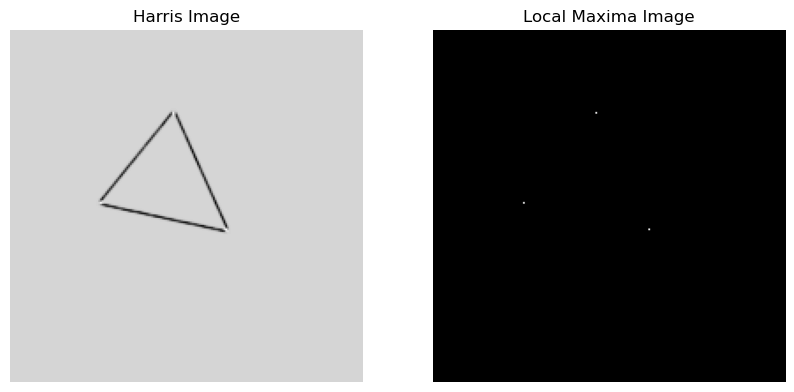

passed


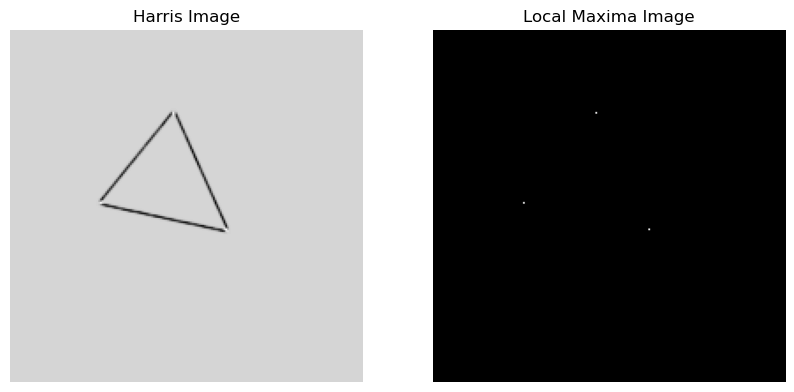

my output: 3
truth: 3
Starting test for TODO 3
passed


0

In [2]:
'''
Nous allons tester ici votre implémentation des TODOs 1, 2 et 3 dans features.py
sur l'exemple d'image triangles1.jpg - N'oubliez pas d'exécuter la cellule précédente
de code Python pour initialiser l’environnement de test.
'''
# construction de l'objet HKD pour la détection des points-clés
HKD = features.HarrisKeypointDetector()
# appel de la fonction de test pour le TO-DO n°1
try_this(1, HKD.computeHarrisValues, [loaded['a'],loaded['b']], compare_array, grayImage)

# patch pour HKD afin que les futurs tests n'échouent pas si le dernier test a échoué
class HKD2(features.HarrisKeypointDetector):
  def computeHarrisValues(self,image):
    return loaded['a'],loaded['b']
HKD=HKD2()
# appel de la fonction de test pour le TO-DO n°2
try_this(2, HKD.computeLocalMaxima, loaded['c'], compare_array, loaded['a'])
print(f'my output: {np.sum(HKD.computeLocalMaxima(loaded["a"]))}')
print(f'truth: {np.sum(loaded["c"])}')
# patch pour HKD afin que les futurs tests n'échouent pas si le dernier test a échoué
class HKD3(HKD2):
  def computeLocalMaxima(self,image):
    return loaded['c']
HKD=HKD3()
# appel de la fonction de test pour le TO-DO n°3
try_this(3, HKD.detectKeypoints, d, compare_cv2_points, image)

### 4.2. Descripteurs associés aux points-clés  ( 35 points )

Une fois les points d'intérêt identifiés, l'étape suivante consiste à associer un *descripteur* à chaque point-clé détecté. Ces descripteurs sont utilisés pour comparer les points-clés identifiés dans les différentes images afin de determiner lesquels correspondent. Vous implémenterez deux versions de descripteurs dans ce devoir :

- Dans un premier temps, vous implémenterez un descripteur simple constitué des valeurs d'intensité de pixel dans un voisinage $5 \times 5$ du point-clé. Cela devrait être facile à mettre en oeuvre et devrait fonctionner correctement quand les images comparées sont liées par une simple translation.

- Ensuite, vous implémenterez une version simplifiée du descripteur MOPS présenté dans le cours '[descripteurs](https://benhadid.github.io/m1vpo/lectures/)'. En ce sens, vous coderez la matrice qui permet de transformer une fenêtre $40 \times 40$ en un patch de $8 \times 8$ pixels après l'avoir pivotée d'un angle $\theta$ autour du point-clé. La nouvelle orientation du point-clé devra être vers la droite.

  Vous devez également normaliser les intensités du patch pour avoir une moyenne nulle et une variance égale à 1. Si la variance du patch avant normalisation est très proche de zéro (inférieure à $10^{-10}$ en valeur absolue), renvoyez simplement un descripteur entièrement nul pour éviter une erreur de division par zéro.
  
  Utilisez `cv2.warpAffine` de OpenCV pour effectuer la transformation. La fonction `warpAffine` requiert une matrice $2 \times 3$ en entrée. La façon la plus simple de générer cette matrice est de combiner plusieurs transformations basiques. Une séquence de translation $\mathbf{T_1}$, rotation $\mathbf{R}$, redimensionnement $\mathbf{S}$ et translation $\mathbf{T_2}$ produira la matrice escompté. Notez que les transformations sont combinées de droite à gauche, de sorte que la matrice de transformation est le produit matriciel $\mathbf{T_2\;S\;R\;T_1}$. Les figures ci-dessous illustrent la séquence.
  

![](warpAffine.png)


#### Code à écrire

Vous devez implémenter deux descripteurs de primitives dans les classes **`SimpleFeatureDescriptor`** et **` MOPSFeaturesDescriptor`**. La méthode **`describeFeatures`** de ces classes prend en entrée les informations de position et d'orientation des points-clés (retournés par le détecteur Harris) et calcule les descripteurs associés. Ces descripteurs sont retournés dans un tableau Numpy bidimensionnel. Le nombre de lignes de ce tableau est égale au nombre de point-clés détectés. Le nombre de colonnes du tableau est égale à la dimension du descripteur retourné (par exemple, 25 pour le descripteur simple de primitives $5 \times 5$).

Pour l'implémentation de MOPS, vous devez créer une matrice pour transformer une fenêtre $40 \times 40$ en un patch de $8 \times 8$ pixels après l'avoir pivotée d'un angle $\theta$ autour du point-clé (comme décrit ci-dessus).

Il est recommandé de consulter la [documentation opencv](https://docs.opencv.org/3.4.9/d4/d61/tutorial_warp_affine.html) sur **`cv2.warpAffine`**.

In [3]:
'''
Nous allons tester ici votre implémentation des TODOs 4, 5 et 6 dans features.py
sur l'exemple d'image triangles1.jpg
'''

# # construction de l'objet SFD pour un descripteur simple d'intensités
SFD = features.SimpleFeatureDescriptor()
# 
# # appel de la fonction de test pour le TO-DO n°4
try_this(4, SFD.describeFeatures, loaded['e'], compare_array, image, d)
# # construction de l'objet MFD pour un descripteur MOPS
MFD = features.MOPSFeatureDescriptor()

# appel de la fonction de test pour le TO-DO n°5 et/ou n°6
try_this('5 and/or 6', MFD.describeFeatures, loaded['f'], compare_array, image, d)

Starting test for TODO 4
passed
Starting test for TODO 5 and/or 6
passed


0

### 4.3. Mise en correspondance de points-clés ( 30 points )

Une fois les points-clés détectés et leurs descripteurs calculés pour un ensemble d'images, l'étape suivante consiste à établir les correspondances entre les différents points-clés identifiés dans les images (c.-à-d., étant donné une primitive dans une image *X*, trouver la meilleure primitive correspondante dans une autre image *Y*).


L'approche la plus simple est la suivante : Pour chaque descripteur d'une image X, le comparer aux descripteurs d'une image *Y* en calculant une *distance* scalaire. La meilleure correspondance est la paire de primitives qui produit la plus petite distance. Vous implémenterez deux fonctions de distance :

1. Somme des Moindres Carrés (SMC): il s'agit de la distance euclidienne au carré entre les deux descripteurs.


2. Ratio de distances : le rapport des distances SMC associées aux deux meilleurs descripteurs identifiés (c.-à-d. le ratio est égale à la distance SMC du descripteur le plus proche divisée par la distance SMC du second descripteur le plus proche).

#### Code à écrire

Dans cette tache, vous allez implémenter une fonction pour la mise en correspondance de primitives. Vous implémenterez la fonction **`matchFeatures`** de **` SSDFeatureMatcher`** et de **`RatioFeatureMatcher`**. Ces fonctions renvoient une liste d'objets [cv2.DMatch](https://docs.opencv.org/3.4.9/d4/de0/classcv_1_1DMatch.html).

Vous devez initialiser l'attribut `queryIdx` de `cv2.DMatch` à l'index de la primitive dans la première image, l'attribut` trainIdx` à l'index de la primitive dans la deuxième image et l'attribut `distance` à la distance (ou le ratio, selon le cas) entre les deux primitives.

Les fonctions `scipy.spatial.distance.cdist` et` numpy.argmin` pourrait vous être utiles lors de l'implémentation de cette tache.


In [4]:
'''
En vous inspirant des tests précédents, vous pouvez implémenter ici vos tests
pour les TODOs 7 et 8 dans features.py
'''
# SSDFM = features.SSDFeatureMatcher()
# # TODO 7: tester la fonction de mise en correspondance 'matchFeatures' de la classe 'SSDFeatureMatcher'
# SSDFM.matchFeatures(loaded['f'][1].reshape(8,8), loaded['f'][2].reshape(8,8))

# TODO 8: tester la fonction de mise en correspondance 'matchFeatures' de la classe 'RatioFeatureMatcher'
RFM = features.RatioFeatureMatcher()
RFM.matchFeatures(loaded['f'][2].reshape(8,8), loaded['f'][1].reshape(8,8))
#print all loaded keys
print(loaded.files)

[< cv2.DMatch 000001C2C1C6D990>, < cv2.DMatch 000001C2C1C6CCF0>, < cv2.DMatch 000001C2C1C6DF70>]
['a', 'b', 'c', 'd_proc', 'e', 'f', 'allow_pickle', 'yosemite_proc', 'anms_proc']


## 5. Tâche bonus (20 points)

Des points supplémentaires sont accordés pour les solutions qui améliorent, d'au moins 15%, l'aire sous la courbe **ROC** (`AUC` dans `featuresUI.py`) pour le test utilisant le "ratio de distances". Une amélioration de 15% est interprétée comme une réduction de 15% de la valeur `(1 - AUC)`. C'est-à-dire la zone au-dessus de la courbe **ROC**. Voici une suggestion (vous êtes également encouragés à proposer vos propres idées !).

 - Implémentez la méthode **`selectKeypointsANMS`** de la classe **`KeypointDetector`**. Cette méthode devrait réaliser la technique de suppression non maximale adaptative discutée dans l'[article MOPS](https://drive.google.com/open?id=1vly0rexasm-kM_lWEulJ-PiBfCDm8cdO)
  
Vous pouvez mesurer votre `AUC` moyenne en exécutant le benchmark de l'interface utilisateur **`featuresUI.py`** sur les cinq ensembles de données (bikes, graf, leuven, wall, yosemite). Les performances de votre implémentation seront évaluées spécifiquement contre l'ensemble de données 'yosemite'. Les implémentations qui n'améliorent pas l'`AUC` moyenne d'au moins 15% ne seront pas notées.

Le bonus sera accordé en fonction du mérite de votre amélioration et de **sa justification**. Les modifications hyper-paramétriques simples recevront moins de points supplémentaires que les améliorations significatives de l'algorithme.

Décrivez votre implémentation dans un fichier nommé **`Lisez-moi_adaptative.txt`** qui décrit vos modifications.


In [5]:
'''
Nous allons tester ici votre implémentation de la tâche  bonus dans features.py
sur l'exemple d'image yosemite1.jpg
'''

ref_keypoints = unpickle_cv2(loaded['yosemite_proc'])
ref_anms_keyoints = unpickle_cv2(loaded['anms_proc'])
student_anms_keypoints = HKD.selectKeypointsANMS(ref_keypoints,100)

Image = cv2.imread('resources/yosemite/yosemite1.jpg')
grayImage   = cv2.cvtColor(Image, cv2.COLOR_BGR2GRAY)

# la selection ANMS réalisée par votre code sera affichée en bleu
student_image = cv2.drawKeypoints(grayImage, student_anms_keypoints, 0, (0, 0, 255),
                                 flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# la selection ANMS corrècte est affichée en rouge
ref_image = cv2.drawKeypoints(grayImage, ref_anms_keyoints, 0, (255, 0, 0),
                                 flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# displaying the image with ref and anms keypoints as the
# output on the screen

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9,4))

axes[0].imshow(student_image, aspect='auto')
axes[0].set_title(f'ANMS (étudiant)', fontsize=12)
axes[0].axis('off')

axes[1].imshow(ref_image, aspect='auto')
axes[1].set_title(f'ANMS (référence)', fontsize=12)
axes[1].axis('off')

fig.tight_layout() # used to adjust padding between subplots

NotImplementedError: Tâche Bonus dans features.py non implémentée !

## 6. Livrables
    
### 6.1. Le code (à remettre sur [benhadid.ddns.net](https://benhadid.ddns.net/course/M1_VPO/hw1))

Le fichier "devoir2.zip" contenant le fichier **`features.py`** et éventuellement un fichier **`Lisez-moi_adaptative.txt`** si vous avez implémenté la tache bonus.

**Le code sera remis <del>en classe pendant votre séance de TP </del> au serveur INGInious - <span style='color:Red'> aucun document ou code ne sera accepté si envoyé par mail ou présenté sur clé USB</span>**.

<del>

### 6.2. Le rapport (à remettre via CanvasLMS)  (15 points)

Éditez un court rapport qui décrit **clairement** votre travail en incluant des résultats d'analyse comparative (benchmark) en termes de courbes ROC et ASC sur le **jeu de données Yosemite** fourni dans le répertoire `resources`. Pour calculer des courbes ROC

1. Exécutez **`featuresUI.py`**.
2. Puis, basculez vers l'onglet "Benchmark" et appuyez sur "Run Benchmark".
3. Ensuite, sélectionnez le répertoire "resources/yosemite".

Enfin, l'ASC sera affichée en bas de l'écran (AUC en anglais) et vous pouvez enregistrer la courbe ROC en appuyant sur "Screenshot". Vous devez également inclure une image du détecteur Harris. Elle est enregistrée sous le nom `harris.png` chaque fois que les points-clés Harris sont calculés.

Le rapport doit contenir les éléments suivants :

- Exécutez le benchmark dans **`featuresUI.py`** sur le jeu de données Yosemite pour les quatre configurations possibles impliquant des descripteurs simples ou MOPS avec SMC ou "ratio de distances". Incluez les courbes ROC résultantes, signalez les ASC obtenues, et indiquez quelle méthode produit les meilleurs résultats, d'après vous.


- Inclure l'image Harris pour "yosemite/yosemite1.jpg". Commentez sur les caractéristiques des régions mises en évidence dans l'image (c.-à-d. les régions où il y a des points-clés détectés). Y a-t-il des régions de l'image qui auraient dû être mises en évidence mais ne le sont pas ?


- Incluez une capture d'écran d'une paire de vos propres images et montrez visuellement les performances de mise en correspondance des primitives pour MOPS + "Ratio de distances".


- Si vous avez réalisé la tache bonus, incluez les courbes ROC et indiquez les ASC de l'ensemble de données Yosemite avec votre algorithme personnalisé en utilisant le "ratio de distances". Décrivez vos modifications apportées à l'algorithme et pourquoi elles améliorent les performances.
</del>

In [1]:
# Exécutez cette cellule puis récupérez votre fichier "devoir2.zip" depuis le panneau gauche dans Colab
# Si nécessaire, faites un 'refresh' sur le répertoire pour faire apparaître le fichier 'devoir2.zip'

# !zip -r ./devoir2.zip features.py
import zipfile
import os

def zip_files(zip_filename, files_to_zip):
    with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for file in files_to_zip:
            zipf.write(file, os.path.basename(file))

zip_files('./devoir2.zip', ['features.py'])